# Time Series Techniques

## Gramian Angular Field

Gramian Angular Difference Field (GADF) permite codificar series temporales a imágenes, permiten realizar una interpretación en una imagen en 2D de una serie temporal univariable.

Coordenadas polares

Podemos convertir series temporales, representadas en un eje de coordenadas cartesianas, donde tenemos un valor en el eje y que es el valor de variable en si, en el eje x tenemos el tiempo que transcurre y como varia esa variable en el tiempo.

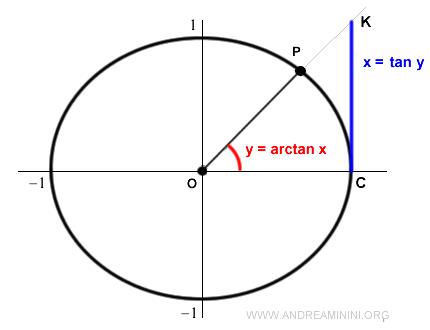

Para convertir a coordenadas polares, representado tal que (r, θ), donde:
+ r (radio) representa la distancia desde el origen.
+ θ (ángulo) representa la dirección del punto respecto a un eje de referencia (como el eje x).

Podemos convertir a coordenadas polares de 2 formas:
+ La primera sería considerar una señal periódica, como un seno o coseno, que parta desde 0 hasta 2pi, este es el periodo de la señal y luego tendríamos que el radio es el valor en si. Visualizar ciclos o estacionalidades (en el método 1).
+ La segunda es medir la diferencia de tiempo que existe entre un instante t y un instante t + 1, y luego se calcula la diferencia del valor de la variable como un delta, y se calcula el angulo entre la delta de tiempo y la delta de la variable. Por tanto sería algo como: θ = arctan(Δy / Δt), r = sqrt((Δt)² + (Δy)²) que mide la magnitud del cambio. Detectar patrones direccionales, como si los cambios tienen una orientación predominante (en el método 2).

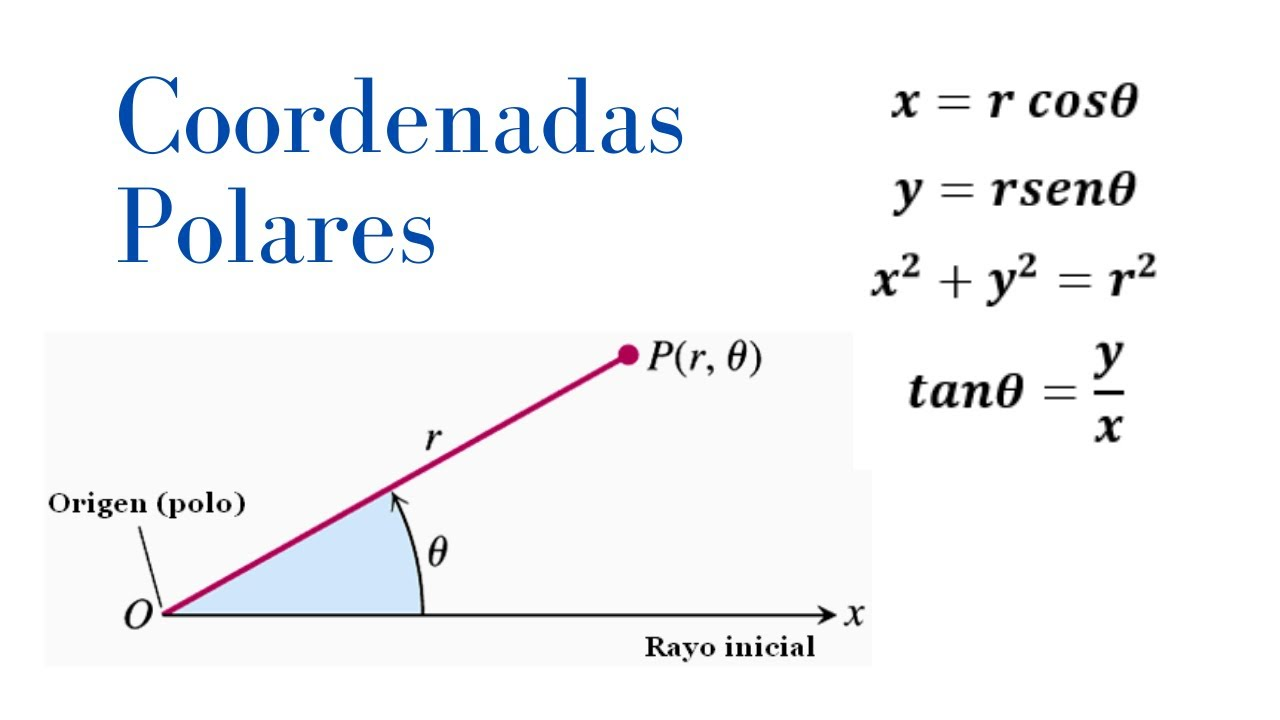

En este caso, como la distribución del tiempo es discreta, que representa los meses, podemos convertirlo a grados haciendo:
+ 2 * math.pi * (t / max(t))
En el caso de tener un formato basado en datetime, con HH:MM:SS, habría que normalizar respecto al tiempo:
+ 2 * math.pi * (t / 24 horas * 3600 segundos), donde t es el tiempo desde las 00:00:00 en segundos

In [ ]:
# Standard libraries
import math


# Datos sintéticos
# Tiempo (por ejemplo, meses)
months = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# Valores sintéticos (algo como una onda)
values = [5, 6, 8, 9, 10, 9, 8, 6, 4, 3, 4, 5]

# Método 1 ----------
theta_1 = [2 * math.pi * (month / len(months)) for month in months]
print(theta_1)

rho_1 = values
print(rho_1)

coord_method1 = [tuple(pair_month_value) for pair_month_value in zip(theta_1, rho_1)]
print(coord_method1)

# Método 2 (valor de la pendiente entre puntos, no del punto en si) ----------
# Lo mejor sería rellanar con 0 los meses en los que no hay datos, así ambos
# arrays tienen la misma cantidad de elementos
theta_2 = []
rho_2 = []
for index, month in enumerate(months):
    if index + 1 < len(values):
        delta_values = values[index + 1] - values[index]
        delta_time = months[index + 1] - month

        # Podría ser que el valor de delta_time fuese cero en ese caso, habría que
        # saturar el valor entre 2pi y -2pi
        if delta_time != 0:
            theta_2.append(math.atan(delta_values / delta_time))
        else:
            theta_2.append(math.pi / 2 if delta_values > 0 else -math.pi / 2)

        rho_2.append(math.sqrt(delta_values**2 + delta_time**2))
print("\n")
print(theta_2)
print(rho_2)
coord_method2 = [tuple(pair_month_value) for pair_month_value in zip(theta_2, rho_2)]
print(coord_method2)

In [ ]:
# 3pps
import matplotlib.pyplot as plt


# Método 1
plt.subplot(1, 2, 1, projection="polar")
plt.plot(theta_1, rho_1, marker="o")
plt.title("Método 1: Tiempo como ángulo")

# Método 2
plt.subplot(1, 2, 2, projection="polar")
plt.plot(theta_2, rho_2, marker="o")
plt.title("Método 2: Cambio como vector")

plt.tight_layout()
plt.show()

Continuando con Gramian, tenemos que la matriz Gramian es una matriz que consiste en realizar el producto vectorial entre cada pareja de vectores.

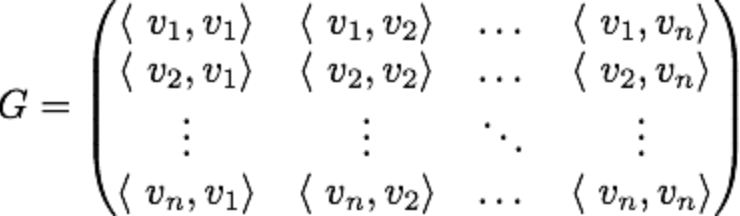

La matriz de Gram preserva la dependencia temporal, pues el tiempo incrementa del mismo modo que lo hace la posición de la matriz 2D de arriba a la izquierda y de arriba a la derecha, por lo que el tiempo se codifica en la geometría de la matriz. Es decir, la matriz mantiene las relaciones angulares entre todos los puntos de la serie. Para ello se siguen los pasos siguientes:

+ Paso 1: Normaliza la serie: Primero necesitas normalizar tu serie a un rango de $[-1, 1]$ (porque luego aplicaremos el arccos):

    $$
    \tilde{x}_i = \frac{x_i - \min(x)}{\max(x) - \min(x)} \times 2 - 1
    $$

+ Paso 2: Convierte los valores a ángulos. Para cada valor de la serie normalizada:

    $$
    \phi_i = \arccos(\tilde{x}_i)
    $$

    Esto convierte cada valor en un **ángulo** entre $0$ y $\pi$, que representa su posición relativa dentro del ciclo.

+ Paso 3: Construye la matriz GADF

    La idea es comparar **cada par de puntos** $(\phi_i, \phi_j)$ de la serie y calcular:

    $$
    \text{GADF}[i,j] = \sin(\phi_i - \phi_j)
    $$

    * Esto mide **la diferencia angular** entre dos puntos.
    * El resultado es una **matriz cuadrada $N \times N$** que puedes tratar como una imagen.

También, existe el **Gramian Angular Summation Field (GASF)** usa la suma en vez de la diferencia:

$$
\text{GASF}[i,j] = \cos(\phi_i + \phi_j)
$$

In [ ]:
# Standard libraries
import math
import random

# 3pps
import matplotlib.pyplot as plt
import numpy as np
from numba import njit


@njit
def normalization(samples: list) -> list:

    min_val = min(samples)
    max_val = max(samples)

    return [((sample - min_val) / (max_val - min_val)) * 2 - 1 for sample in samples]


@njit
def degrees(samples: list) -> list:

    return [math.acos(sample) for sample in samples]


@njit
def gadf_matrix(samples: list) -> list:

    norm_samples = normalization(samples)
    theta_samples = degrees(norm_samples)

    n = len(samples)
    gadf_matrix_list = []

    for sample_i in theta_samples:
        for sample_j in theta_samples:
            gadf_matrix_list.append(math.sin(sample_i - sample_j))

    return np.array(gadf_matrix_list).reshape(n, n)


@njit
def gasf_matrix(samples: list) -> list:

    norm_samples = normalization(samples)
    theta_samples = degrees(norm_samples)

    n = len(samples)
    gadf_matrix_list = []

    for sample_i in theta_samples:
        for sample_j in theta_samples:
            gadf_matrix_list.append(math.cos(sample_i + sample_j))

    return np.array(gadf_matrix_list).reshape(n, n)


# Datos temporales (por ejemplo, 16 puntos en el tiempo)
x = random.sample(range(1, 4000), 2400)
x_gadf_matrix = gadf_matrix(samples=x)
x_gasf_matrix = gasf_matrix(samples=x)

print(x_gadf_matrix.shape)
print(x_gasf_matrix.shape)

plt.imshow(x_gadf_matrix, origin="upper")
plt.colorbar()
plt.show()

plt.imshow(x_gasf_matrix, origin="upper")
plt.colorbar()
plt.show()